# Figure 9

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# My packages
from aeolus.calc import div_h, integrate, meridional_mean, time_mean, zonal_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.meta import const_from_attrs, preserve_shape
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator
from pouch.clim_diag import calc_derived_cubes, moist_static_energy
from pouch.plot import (
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    XLOCS,
    figsave,
    use_style,
)

In [4]:
# Local modules
import mypaths
from commons import GLM_SUITE_ID, SIM_LABELS

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load model data from the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_mean"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days6000_9950"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
runs = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    if sim_label == "base":
        time_prof = "mean_days6000_9950"
    elif sim_label == "sens-noradcld":
        time_prof = "mean_days2000_2200"
    else:
        time_prof = "mean_days2000_2950"
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Use the cube list to initialise an AtmoSim object
    calc_derived_cubes(cl, const=const)
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
    )

## Choose variables and perform calculations needed

Set display settings for the chosen variables.

In [8]:
WIND_CMPNT_META = {
    "total": {"title": "Total", "qk_ref_wspd": 60, "kw_plt": dict(color="#222222")},
    "div": {"title": "Divergent", "qk_ref_wspd": 10, "kw_plt": dict(color="tab:blue")},
    "rot": {
        "title": "Rotational",
        "qk_ref_wspd": 60,
        "kw_plt": dict(color="tab:brown"),
    },
}

$\rho$ inside the Helmholtz decomposition

In [9]:
@const_from_attrs()
def wind_rot_div_with_rho(
    u, v, rho, opt="residual", truncation=None, const=None, model=um
):
    """Rho-weighted Helmholtz decomposition."""
    from windspharm.iris import VectorWind

    vec = VectorWind(u * rho, v * rho, rsphere=const.radius.data)
    div_cmpnt_u, div_cmpnt_v, rot_cmpnt_u, rot_cmpnt_v = vec.helmholtz(
        truncation=truncation
    )
    out = {}
    out["u_total"] = u
    out["v_total"] = v
    out["u_div"] = iris.util.reverse(div_cmpnt_u, model.y) / rho
    out["u_div"].units = u.units
    out["v_div"] = iris.util.reverse(div_cmpnt_v, model.y) / rho
    out["v_div"].units = v.units
    if opt == "residual":
        out["u_rot"] = u - out["u_div"]
        out["v_rot"] = v - out["v_div"]
    elif opt == "separate":
        out["u_rot"] = iris.util.reverse(rot_cmpnt_u, model.y) / rho
        out["u_rot"].units = u.units
        out["v_rot"] = iris.util.reverse(rot_cmpnt_v, model.y) / rho
        out["v_rot"].units = v.units
    for cmpnt in ["u", "v"]:
        rot_cmpnt = out[f"{cmpnt}_rot"]
        out[f"{cmpnt}_rot_zm"] = preserve_shape(zonal_mean)(rot_cmpnt)
        out[f"{cmpnt}_rot_zm"].rename(f"zonal_mean_of_{rot_cmpnt.name()}")
        out[f"{cmpnt}_rot_eddy"] = rot_cmpnt - out[f"{cmpnt}_rot_zm"]
        out[f"{cmpnt}_rot_eddy"].rename(f"zonal_deviation_of_{rot_cmpnt.name()}")
    return out

Local function to calculate vertical integrals of the MSE flux divergence components.

In [10]:
@const_from_attrs()
def flux_div_h_int_v(
    flux_x,
    flux_y,
    rho=None,
    const=None,
    truncation=None,
    weight_opt=None,
    div_opt="finite_diff",
    model=um,
):
    """Vertical integral of the horizontal flux divergence."""
    from cf_units import Unit

    if weight_opt in ["before", "after"] and rho is None:
        raise ValueError("Weights (rho) are not supplied.")

    if weight_opt == "before":
        flux_x *= rho
        flux_y *= rho
    if div_opt == "spectral":
        from windspharm.iris import VectorWind

        vec = VectorWind(flux_x, flux_y, rsphere=const.radius.data)
        hdiv = vec.divergence(truncation=truncation)
        hdiv.units = flux_y.units / Unit("m")
    elif div_opt == "finite_diff":
        hdiv = div_h(flux_x, flux_y, model=model)
        hdiv.convert_units(flux_y.units / Unit("m"))
    if weight_opt == "after":
        hdiv *= rho
    out = integrate(hdiv, model.z)
    out = meridional_mean(out)
    return out

Store results in a `RESULTS` dictionary for each of the experiments.

In [11]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]
    RESULTS[sim_label]["lons"] = the_run.coord.x.points

    u = time_mean(the_run.u)
    v = time_mean(the_run.v)
    rho = time_mean(the_run.dens)
    RESULTS[sim_label]["toa_net"] = meridional_mean(time_mean(the_run.toa_net_energy))

    wind_cmpnts = wind_rot_div_with_rho(u, v, rho, opt="residual")
    mse_cmpnts = {
        k: time_mean(val) for k, val in moist_static_energy(the_run._cubes).items()
    }

    # mse_hdiv_cmpnts = {}
    for mse_key, cmpnt in mse_cmpnts.items():
        RESULTS[sim_label][mse_key] = {}
        for wind_key, _ in WIND_CMPNT_META.items():
            u_cmpnt, v_cmpnt = (
                wind_cmpnts[f"u_{wind_key}"],
                wind_cmpnts[f"v_{wind_key}"],
            )
            f_x = u_cmpnt * cmpnt
            f_y = v_cmpnt * cmpnt
            RESULTS[sim_label][mse_key][wind_key] = flux_div_h_int_v(
                f_x,
                f_y,
                rho,
                weight_opt="before",
                const=runs[sim_label].const,
                truncation=None,
            )
            RESULTS[sim_label][mse_key][wind_key] *= -1  # Convert to convergence
            RESULTS[sim_label][mse_key][wind_key].convert_units("W m^-2")

## Create the figure

In [12]:
mse_key = "mse"
title = "Moist static energy budget"
# mse_key = "lse"
# title = "Moist static energy budget: latent component"

imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__tmm_rot_div_flux_{mse_key}__tot_rot"  # __with_rho_residual

ncols = len(SIM_LABELS)
nrows = 1

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(16, 4),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
    squeeze=False,
)

iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.axhline(0, **KW_ZERO_LINE)
    for _lon in [-90, 0, 90]:
        ax.axvline(_lon, **KW_ZERO_LINE)
    # ax.set_ylim(-350, 350)
    ax.set_ylim(-500, 500)
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    if ax.is_first_col():
        ax.set_ylabel("Energy flux [$W$ $m^{-2}$]", fontsize="medium")
    # if ax.is_last_row():
    ax.set_xlabel("Longitude [$\degree$]", fontsize="medium")

for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    for wind_key, wind_meta in WIND_CMPNT_META.items():
        ax.plot(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label][mse_key][wind_key].data,
            **wind_meta["kw_plt"],
        )
    ax.plot(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["toa_net"].data,
        color="C1",
    )
    if mse_key == "mse":
        ax.plot(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["toa_net"].data
            + RESULTS[sim_label][mse_key]["total"].data,
            linestyle="--",
            color="k",
        )
add_custom_legend(
    fig,
    {
        **{"TOA net energy flux": {"color": "C1"}},
        **{v["title"]: v["kw_plt"] for v in WIND_CMPNT_META.values()},
        **{"Residual": {"linestyle": "--", "color": "k"}},
    },
    title=title,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    frameon=False,
    ncol=3,
)

plt.close()

# Show the figure

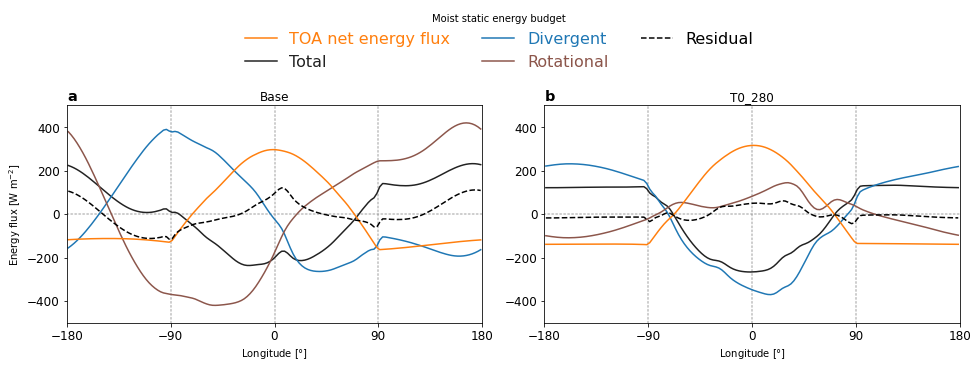

In [13]:
fig

* **The steady state moist static energy (MSE) budget for the (a) _Base_ (SJ regime) and (b) _T0\_280_ (DJ regime) simulations.**

### Background theory (see Hammond & Lewis, 2021)

$s = c_p T + gz + L q$

$\langle\nabla \cdot s \mathbf{u}\rangle+F_{\mathrm{ISR}}-F_{\mathrm{OSR}}-F_{\mathrm{OLR}}=0$

Why does divergent dominate?
$$
\nabla_{p} \cdot s \boldsymbol{u}=s \nabla_{p} \cdot \boldsymbol{u}+\boldsymbol{u} \cdot \nabla_{p} s
$$
Slowly rotating terrestrial planet:
WTG regime, which means
$$
\nabla_{p} s \approx 0
$$
so that
$$
\nabla_{p} \cdot s \boldsymbol{u} \approx s \nabla_{p} \cdot \boldsymbol{u}=s \nabla_{p} \cdot \boldsymbol{u}_{\mathrm{D}}
$$

See also: https://exoclim.github.io/aeolus/examples/04_Rotational_And_Divergent_Winds.html

In [14]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_mean/ch111_mean__base_sens-t280k__tmm_rot_div_flux_mse__tot_rot.png
